 # Introdução

O objetivo desse notebook é criar um modelo de predição de gorjetas para as corridas de táxi de Chicago. A base de dados utilizada foi a [Chicago Taxi Trips](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew), por ser uma base de dados grande vai ser utilizado PySpark para o tratamento dos dados e criação do modelo de machine learning (**ML**).

## Colunas da base utilizadas como entrada

As colunas utilizadas como entrada para modelo de ML desenvolvido vão ser:
* **Trip Start Timestamp**, a partir dela vai ser derivada a coluna trip_start_hour
* **Trip End Timestamp**, a partir dela vai ser derivada a coluna trip_end_hour
* **Pickup Community Area**, apenas as 11 áreas  mais frequentes vão ter o nome mantido as outras vão receber o nome m1
* **Dropoff Community Area**, apenas as 11 áreas  mais frequentes vão ter o nome mantido as outras vão receber o nome m1
* **Company**,  apenas as 19 companias mais frequentes vão ter o nome mantido, as outras vão receber nome m1
* **Payment type**
* Trip miles
* Trip seconds
* Fare
* Tolls
* Extras

As colunas em negrito são de dados discretos. Esses dados passaram por um processo de pivoteamento, para que assim sejam criadas colunas númericas a partir destas.

## Modelo de Machine learning utilizado

O modelo de machine learning utilizado vai ser decido com base nas métricas alcançadas pela criação automatizada de vários modelos de ML, utilizando o **Pycaret**, em uma pequena amostra da base de dados. Apenas 1% da base foi utilizada como amostra, por questões de recursos computacionais, isso corresponde a um pouco mais que 160 mil registros de corridas de táxi.

# Configuração do ambiente

Download dos pacotes necessarios


In [1]:
!pip install pyspark
!pip install pandas
!pip install pycaret
!pip install seaborn

 Carregamento dos pacotes

In [1]:
import os
import pandas as pd
from pyspark.sql import SparkSession
import pyspark
import re
from pyspark.sql.functions import col, udf
import time
import datetime
import pyspark.sql.functions as F
from pyspark.sql.functions import expr
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.tree import RandomForest
from pyspark.ml.regression import RandomForestRegressor
import pycaret
import numpy as np

 Inicialização do spark

In [2]:
import os 
os.environ["SPARK_LOCAL_DIRS"]='spark_temp'

MAX_MEMORY = "10g"

spark = SparkSession.builder.appName('sparkdf341')\
        .config("spark.executor.memory", MAX_MEMORY)\
        .config("spark.driver.memory", MAX_MEMORY)\
        .config("spark.local.dir",os.environ["SPARK_LOCAL_DIRS"])\
        .getOrCreate()


23/01/15 21:16:56 WARN Utils: Your hostname, DESKTOP-DHUKHBA resolves to a loopback address: 127.0.1.1; using 172.22.52.77 instead (on interface eth0)
23/01/15 21:16:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/15 21:16:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/01/15 21:16:57 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Suspende warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')
spark.sparkContext.setLogLevel('ERROR')


 # Carregamento e otmizações na base de dados

 A base de dados fica armazenado na variável **df**

  ---

 Carregamento da base

In [5]:
pathToDatabse='database.csv'
pathToParquet='database.parquet'

if(os.path.exists(pathToDatabse)==False):
    os.system('curl https://data.cityofchicago.org/api/views/wrvz-psew/rows.tsv?accessType=DOWNLOAD  -o '+pathToDatabse)

df=spark.read.csv(pathToDatabse, header=True,sep='\t')

 Otimização da base

In [6]:
def remove_special_characters(df):
    columns=list(df.columns)
    for col in columns:
        col1=col.replace(" ","_")
        col1=re.sub(r"[^a-zA-Z0-9 ]", "_", col1)
        
        df=df.withColumnRenamed(col,col1)
    return df

def get_date_from_datetime_in_str(x):
    try:
        return datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p').strftime('%Y-%m-%d')
    except:
        return "-1"
    

def get_time_from_datetime_in_str(x):
    try:
        return datetime.datetime.strptime(x,'%m/%d/%Y %I:%M:%S %p').strftime('%H:%M')
    except:
        return "-1"

if(os.path.exists(pathToParquet)==False):
    get_time_from_datetime_in_str_udf=udf(lambda z: get_time_from_datetime_in_str(z))
    get_date_from_datetime_in_str_udf=udf(lambda z: get_date_from_datetime_in_str(z))
    df_t=df
    df_t=df_t.withColumn("Trip Start Timestamp Hour Minute",
                     get_time_from_datetime_in_str_udf(col("Trip Start Timestamp")))
    df_t=df_t.withColumn("Trip Start Timestamp Date",
                     get_date_from_datetime_in_str_udf(col("Trip Start Timestamp")))

    df_t=df_t.withColumn("Trip End Timestamp Hour Minute",
                     get_time_from_datetime_in_str_udf(col("Trip End Timestamp")))
    df_t=df_t.withColumn("Trip End Timestamp Date",
                     get_date_from_datetime_in_str_udf(col("Trip End Timestamp")))



    df_t=remove_special_characters(df_t)
    try:
        df_t.write.partitionBy("Trip_Start_Timestamp_Date").parquet(pathToParquet)
    except:
        pass

df=spark.read.parquet(pathToParquet)
n_rows_df=df.count()

 Converter dados da base

In [7]:
df=df.withColumn("Trip_Miles",df.Trip_Miles.cast('double'))
df=df.withColumn("Trip_Seconds",df.Trip_Seconds.cast('double'))
df=df.withColumn("Fare",df.Fare.cast('double'))
df=df.withColumn("Tolls",df.Tolls.cast('double'))
df=df.withColumn("Extras",df.Extras.cast('double'))
df=df.withColumn("Trip_Total",df.Trip_Total.cast('double'))
df=df.withColumn("Tips",df.Tips.cast('double'))

 # Tratamento da base de dados
 ## Retirar linha inválidas da base
 Retirar linhas onde **Trip_Miles** é igual a zero ou **Trip_Seconds** é igual a zero

In [8]:
df=df[(df['Trip_Miles']>0.0) & (df['Trip_Seconds']>0.0)]

 Porcentagem da quantidades de linhas que permaneceram

In [9]:
print(df.count()/n_rows_df)
n_rows_df=df.count()

0.7857097290668086


 ## Normalizar os nomes das companias
 Companias com pouca frequência vão ter o nome 'm1'
 ### Tabela mostrando a curva de pareto para a frequência dos nomes das companias

In [10]:
df_pareto_company=df.groupBy("Company")\
                    .count()\
                    .withColumnRenamed('count','count_company')\
                    .orderBy(col('count_company').desc())
df_pareto_company=df_pareto_company.withColumn('cumsum',
                                             expr('sum(count_company) over (order by count_company desc)'))

df_pareto_company=df_pareto_company.withColumn('pareto',df_pareto_company['cumsum']/n_rows_df)
df_pareto_company[['Company','pareto']].show()

+--------------------+-------------------+
|             Company|             pareto|
+--------------------+-------------------+
|                null|0.19986685092742143|
|Taxi Affiliation ...| 0.3605392378862002|
|           Flash Cab| 0.4786760961159568|
|          Yellow Cab| 0.5378961097069753|
|Dispatch Taxi Aff...| 0.5876181623394462|
|Chicago Carriage ...| 0.6362457259884621|
|Choice Taxi Assoc...|  0.675038622154915|
|        City Service| 0.7115138003563017|
|            Sun Taxi| 0.7478888509028575|
|    Medallion Leasin| 0.7782671124868998|
|Taxi Affiliation ...| 0.7999540996074587|
|     American United| 0.8186120463810999|
|Northwest Managem...| 0.8357287635671153|
|          Globe Taxi| 0.8514234951740379|
|Blue Ribbon Taxi ...|  0.866481616134103|
|Star North Manage...| 0.8814918280541819|
|KOAM Taxi Associa...| 0.8933410880805897|
| Top Cab Affiliation| 0.9039738913144498|
|            303 Taxi| 0.9132295397414473|
|        Checker Taxi| 0.9219692393989045|
+----------

 ### Normaliza/Seta para 'm1' os nomes das companias para companias abaixo das 19 primeiras mais frequentes.

In [11]:
companies_most_importants=[]
companies_most_importants_row_format=df_pareto_company[['Company']].head(19)
for company in companies_most_importants_row_format:
    companies_most_importants.append(company['Company'])

normalize_company_names_udf=udf(lambda x:  x if(x in companies_most_importants) else 'm1')
df=df.withColumn("company_normalized",
                     normalize_company_names_udf(col("Company")))

 ## Normalizar as áreas de Pickup
 Áreas com pouca frequência vão ter o valor m1


 Áreas com valores null vão ter o valor m2
 ### Substituir valores null por m2

In [12]:
df=df.fillna('m2', subset=['Pickup_Community_Area'])

 ### Tabela mostrando a curva de pareto para a frequência das Áreas

In [13]:
df_pareto_area_pickup=df.groupBy("Pickup_Community_Area")\
                    .count()\
                    .withColumnRenamed('count','count_area_pickup')\
                    .orderBy(col('count_area_pickup').desc())
df_pareto_area_pickup=df_pareto_area_pickup.withColumn('cumsum',
                                             expr('sum(count_area_pickup) over (order by count_area_pickup desc)'))

df_pareto_area_pickup=df_pareto_area_pickup.withColumn('pareto',df_pareto_area_pickup['cumsum']/n_rows_df)
df_pareto_area_pickup[['Pickup_Community_Area','pareto']].show()

+---------------------+------------------+
|Pickup_Community_Area|            pareto|
+---------------------+------------------+
|                    8| 0.295146140761722|
|                   32|0.5105832306855411|
|                   28| 0.597641151402734|
|                   m2|0.6816039018753958|
|                   76|0.7538399322532344|
|                    6|0.8070128287586077|
|                    7|0.8480071092438359|
|                   24|0.8744267993368976|
|                   33| 0.898688095141483|
|                   56|0.9171572850238076|
|                    3| 0.930941768035734|
|                   77|0.9402904983046985|
|                   22|0.9496135514674708|
|                    5|0.9546853240786302|
|                    4|0.9592948528098288|
|                    1| 0.963423574773689|
|                    2|0.9672347190046809|
|                   41|0.9708180216719378|
|                   16|0.9743026829590984|
|                   21|0.9766056687699942|
+----------

 ### Normaliza/Seta para m1 os nomes das áreas para as áreas abaixo das 11 primeiras mais frequentes.

In [14]:
pickup_areas_most_importants=[]
pickup_areas_most_importants_row_format=df_pareto_area_pickup[['Pickup_Community_Area']].head(11)
for area in pickup_areas_most_importants_row_format:
    pickup_areas_most_importants.append(area['Pickup_Community_Area'])

normalize_pickup_area_udf=udf(lambda x:  x if(x in pickup_areas_most_importants) else 'm1')
df=df.withColumn("pickup_area_normalized",
                     normalize_pickup_area_udf(col("Pickup_Community_Area")))

 ## Normalizar as áreas de Dropoff
 Áreas com pouca frequência vão ter o valor m1


 Áreas com valores null vão ter o valor m2
 ### Substituir valores null por m2

In [15]:
df=df.fillna('m2', subset=['Dropoff_Community_Area'])

 ### Tabela mostrando a curva de pareto para a frequência das Áreas

In [16]:
df_pareto_area_dropoff=df.groupBy("Dropoff_Community_Area")\
                    .count()\
                    .withColumnRenamed('count','count_area_dropoff')\
                    .orderBy(col('count_area_dropoff').desc())
df_pareto_area_dropoff=df_pareto_area_dropoff.withColumn('cumsum',
                                             expr('sum(count_area_dropoff) over (order by count_area_dropoff desc)'))

df_pareto_area_dropoff=df_pareto_area_dropoff.withColumn('pareto',df_pareto_area_dropoff['cumsum']/n_rows_df)
df_pareto_area_dropoff[['dropoff_Community_Area','pareto']].show()

+----------------------+------------------+
|dropoff_Community_Area|            pareto|
+----------------------+------------------+
|                     8|0.2664798686730132|
|                    32|0.4480058406243971|
|                    m2|0.5527192126972638|
|                    28| 0.645471648920764|
|                     6| 0.704076214178408|
|                     7|0.7578312266632713|
|                    24|0.7974227933911768|
|                    76|0.8338368291105874|
|                    33|0.8639499119195658|
|                     3|0.8809389089779545|
|                    22|0.8962185781543421|
|                    56|0.9080152029114816|
|                    77|0.9191573319751642|
|                     5|0.9277074289950125|
|                     4|0.9348383637358915|
|                     1|0.9404693487706907|
|                    16|0.9455919407840784|
|                    41|0.9507002608287785|
|                     2|0.9554649218174404|
|                    21|0.959343

 ### Normaliza/Seta para m1 os nomes das áreas para as áreas abaixo das 11 primeiras mais frequentes.

In [17]:
dropoff_areas_most_importants=[]
dropoff_areas_most_importants_row_format=df_pareto_area_dropoff[['Dropoff_Community_Area']].head(11)
for area in dropoff_areas_most_importants_row_format:
    dropoff_areas_most_importants.append(area['Dropoff_Community_Area'])

normalize_dropoff_area_udf=udf(lambda x:  x if(x in dropoff_areas_most_importants) else 'm1')
df=df.withColumn("dropoff_area_normalized",
                     normalize_dropoff_area_udf(col("Dropoff_Community_Area")))

 ## Faz um pivoteamento da informacao hora nos campos Trip_End_Timestamp_Hour_Minute e Trip_Start_Timestamp_Hour_Minute

In [18]:
columns_to_use=["Trip_ID",'Trip_Miles','Trip_Seconds',
                'Fare','Tips','Tolls','Extras','Trip_Total']

 ### Cria o campos de hora sem os minutos

In [19]:
extract_hour_udf=udf(lambda z: z.split(":")[0])
df_1=df.withColumn("trip_start_hour",
                  extract_hour_udf(col("Trip_Start_Timestamp_Hour_Minute")))

df_1=df_1.withColumn("trip_end_hour",
                  extract_hour_udf(col("Trip_End_Timestamp_Hour_Minute")))

 ### Pivoteamento dos campos de horas

In [20]:
columns_to_useT=columns_to_use+['trip_end_hour',"Trip_End_Timestamp_Date"]+['pickup_area_normalized','dropoff_area_normalized','company_normalized','Payment_Type']
df_1=df_1.groupBy(columns_to_useT).pivot("trip_start_hour").count()
for c in df_1.columns:
    if(not(c  in  columns_to_useT)):
        df_1=df_1.withColumnRenamed(c,'trip_start_hour__'+c)
        columns_to_use.append('trip_start_hour__'+c)


columns_to_useT=columns_to_use+["Trip_End_Timestamp_Date"]+['pickup_area_normalized','dropoff_area_normalized','company_normalized','Payment_Type']
df_1=df_1.groupBy(columns_to_useT).pivot("trip_end_hour").count()
for c in df_1.columns:
    if(not(c  in  columns_to_useT)):
        df_1=df_1.withColumnRenamed(c,'trip_end_hour__'+c)
        columns_to_use.append('trip_end_hour__'+c)

 ### Cria o campo mês sem dia ou ano

In [21]:
extract_month_udf=udf(lambda z: z.split("-")[1])


df_1=df_1.withColumn("trip_month",
                  extract_month_udf(col("Trip_End_Timestamp_Date")))

 ### Pivoteamento do campo mês

In [22]:
columns_to_useT=columns_to_use+['pickup_area_normalized','dropoff_area_normalized','company_normalized','Payment_Type']
df_1=df_1.groupBy(columns_to_useT).pivot("trip_month").count()
for c in df_1.columns:
    if(not(c  in  columns_to_useT)):
        df_1=df_1.withColumnRenamed(c,'trip_month__'+c)
        columns_to_use.append('trip_month__'+c)


df=df_1

 ##Substituir campos nulos em Patment_Type por 'm1'

In [23]:
df=df.fillna('m1', subset=['Payment_Type'])

 ## Pivoteamento das colunas dropoff_area_normalized, pickup_area_normalized e company_normalized.

In [24]:
columns_to_useT=columns_to_use+['pickup_area_normalized','company_normalized','Payment_Type']
df_1=df.groupBy(columns_to_useT).pivot("dropoff_area_normalized").count()

for c in df_1.columns:
    if(not(c  in  columns_to_useT)):
        df_1=df_1.withColumnRenamed(c,'dropoff_area__'+c)
        columns_to_use.append('dropoff_area__'+c)



columns_to_useT=columns_to_use+['company_normalized','Payment_Type']
df_1=df_1.groupBy(columns_to_useT).pivot("pickup_area_normalized").count()       

for c in df_1.columns:
    if(not(c  in  columns_to_useT)):
        df_1=df_1.withColumnRenamed(c,'pickup_area__'+c)
        columns_to_use.append('pickup_area__'+c)
        

columns_to_useT=columns_to_use+['Payment_Type']
df_1=df_1.groupBy(columns_to_useT)\
       .pivot("company_normalized").count()


for c in df_1.columns:
    if(not(c  in  columns_to_useT)):
        newNameForC=c.replace(" ","_")
        newNameForC=re.sub(r"[^a-zA-Z0-9 ]", "_", newNameForC)
        df_1=df_1.withColumnRenamed(c,'company__'+newNameForC)
        columns_to_use.append('company__'+newNameForC)


df_1=df_1.groupBy(columns_to_use)\
         .pivot("Payment_Type").count()
for c in df_1.columns:
    if(not(c  in  columns_to_use)):
        newNameForC=c.replace(" ","_")
        newNameForC=re.sub(r"[^a-zA-Z0-9 ]", "_", c)
        df_1=df_1.withColumnRenamed(c,'payment_type__'+newNameForC)
        columns_to_use.append('payment_type__'+newNameForC)

 ## Trocar None por 0 nos campos

In [25]:
df=df_1.fillna(0)

 ## Imprimir algumas linhas para ver se esta tudo certo

In [26]:
df[df['Trip_ID']=='653f058e33c4fbeeaf20af84f2f57e2cecdb7d4e'].collect()

[Row(Trip_ID='653f058e33c4fbeeaf20af84f2f57e2cecdb7d4e', Trip_Miles=1.0, Trip_Seconds=300.0, Fare=6.0, Tips=2.0, Tolls=0.0, Extras=1.0, Trip_Total=9.5, trip_start_hour__00=0, trip_start_hour__01=0, trip_start_hour__02=0, trip_start_hour__03=0, trip_start_hour__04=0, trip_start_hour__05=0, trip_start_hour__06=0, trip_start_hour__07=0, trip_start_hour__08=0, trip_start_hour__09=0, trip_start_hour__10=0, trip_start_hour__11=0, trip_start_hour__12=0, trip_start_hour__13=0, trip_start_hour__14=0, trip_start_hour__15=0, trip_start_hour__16=0, trip_start_hour__17=0, trip_start_hour__18=0, trip_start_hour__19=0, trip_start_hour__20=1, trip_start_hour__21=0, trip_start_hour__22=0, trip_start_hour__23=0, trip_end_hour__00=0, trip_end_hour__01=0, trip_end_hour__02=0, trip_end_hour__03=0, trip_end_hour__04=0, trip_end_hour__05=0, trip_end_hour__06=0, trip_end_hour__07=0, trip_end_hour__08=0, trip_end_hour__09=0, trip_end_hour__10=0, trip_end_hour__11=0, trip_end_hour__12=0, trip_end_hour__13=0, tr

 ## Salva os resultados obtidos até agora

In [27]:
df=remove_special_characters(df)
df.write.parquet('temp.parquet')

 ## Carrega os resultados obtidos até agora

In [3]:
df=spark.read.parquet('temp.parquet')

# Análise da distribuição das gorjetas
Para ter um melhor entendimento de algumas metricas de qualidade do modelos de ML (como **MAE* e **MSE**) é necessário fazer uma análise distribuição do atributo predito. A seguir um histograma com a distribuição das gorjetas em uma amostra de 30% da base de dados:

<AxesSubplot: xlabel='Tips', ylabel='Count'>

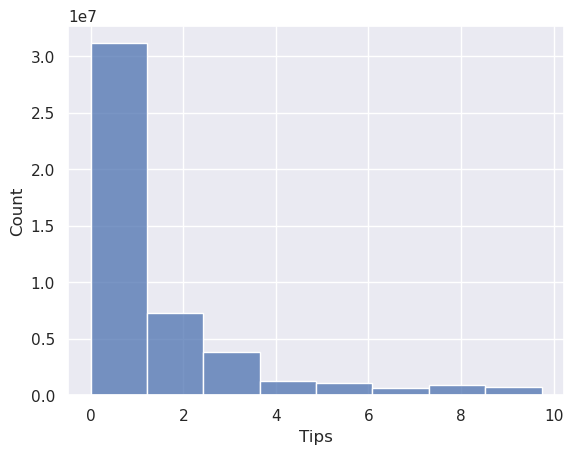

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats
import shutil
def get_column___tips___from_pyspark(df_pyspark):
    #I need to save df[['Tips']] in a CSV file because the PySpark use many ram to convert a
    #dataframe to pandas
    df_tips=df_pyspark[['Tips']].repartition(1).write.csv('data_to_plot_histogram.csv',header=True)
    files=os.listdir("data_to_plot_histogram.csv")
    file_csv=''
    for file in files:
        if(file[-3:]=='csv'):
            file_csv=file
            break
    
    df_dataframe=pd.read_csv("data_to_plot_histogram.csv/"+file_csv)
    shutil.rmtree("data_to_plot_histogram.csv")
    return df_dataframe
    
    
sns.set(style="darkgrid")
df_tips= get_column___tips___from_pyspark(df.sample(0.3))
df_tips2=df_tips[(np.abs(stats.zscore(df_tips)) < 3)]# Remove outliers
sns.histplot(data=df_tips2, x="Tips",bins=8)

# Estudo do modelo de ML a ser utilizado e análise das variáveis

## Colher uma amostras dos dados para utilizar no Pycaret e Scikit



In [7]:
df_sample=df.sample(0.001,seed=20).toPandas()
df_sample

,Trip_ID,Trip_Miles,Trip_Seconds,Fare,Tips,Tolls,Extras,Trip_Total,trip_start_hour__00,trip_start_hour__01,...,payment_type__Credit_Card,payment_type__Dispute,payment_type__Mobile,payment_type__No_Charge,payment_type__Pcard,payment_type__Prcard,payment_type__Prepaid,payment_type__Split,payment_type__Unknown,payment_type__Way2ride
0,47ac08f15da8006536f32560241172bc3190c9e5,7.20,1696.0,22.25,5.56,0.0,0.0,27.81,0,0,...,1,0,0,0,0,0,0,0,0,0
1,aa2332b5131d25ac49e5ee6bf10816afc36d9e71,1.10,295.0,5.65,0.00,0.0,0.0,5.65,0,0,...,0,0,0,0,0,0,0,0,0,0
2,aeb352237f5ab7c99e0e27e1d2c39c93c1582169,1.90,1020.0,9.85,0.00,0.0,0.0,9.85,0,0,...,0,0,0,0,0,0,0,0,0,0
3,001234b5797af723de2b203c70946e8f6567c49c,2.00,600.0,8.25,0.00,0.0,0.0,8.25,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1fb180ff78fb0c3c301d4abca8e1251eaf8cb5a9,6.76,1079.0,20.50,0.00,0.0,0.0,20.50,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161067,ff7bd93f201759019609317600b8b403710056f6,1.80,587.0,8.25,0.00,0.0,1.0,9.25,0,0,...,0,0,0,0,0,0,0,0,0,0
161068,ff821a659c47aa253ef52281215ccb227ba08839,2.21,977.0,11.00,1.88,0.0,1.0,13.88,0,0,...,0,0,0,0,0,1,0,0,0,0
161069,ffbe6535bd8972039b7a081470c2ddce1a449b34,11.00,1920.0,24.45,0.00,0.0,2.0,26.45,0,0,...,0,0,0,0,0,0,0,0,0,0
161070,ffdecebd63f126d278de2634f0e54fedfe378e98,0.70,1320.0,26.05,0.00,0.0,2.0,28.05,0,0,...,0,0,0,0,0,0,0,0,0,0


## Analisar pela amostra qual o melhor modelo de ML usando PyCaret

In [9]:

from pycaret.regression import *
import warnings
warnings.filterwarnings('ignore')

df_sample_pycaret=df_sample.drop(['Trip_ID','Trip_Total'], axis=1).copy()
exp_reg101 = setup(data = df_sample_pycaret, target = 'Tips',normalize = True,silent=True) 
compare_models(exclude=['knn','gbr'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.4297,1.5699,1.2518,0.7889,0.2798,0.5734,0.2740
rf,Random Forest Regressor,0.4459,1.6365,1.2781,0.7799,0.2847,0.5829,20.1270
et,Extra Trees Regressor,0.4614,1.7640,1.3268,0.7627,0.2903,0.6004,28.7190
dt,Decision Tree Regressor,0.6184,3.1856,1.7818,0.5713,0.3925,0.7112,0.3380
lr,Linear Regression,0.9767,3.7109,1.8766,0.5079,0.4945,0.8261,0.4120
ridge,Ridge Regression,0.9763,3.7111,1.8767,0.5079,0.4943,0.8259,0.0440
br,Bayesian Ridge,0.9751,3.7127,1.8770,0.5077,0.4935,0.8257,1.5530
omp,Orthogonal Matching Pursuit,0.9701,3.7191,1.8805,0.5067,0.4888,0.8284,0.1350
huber,Huber Regressor,0.8139,3.9915,1.9913,0.4637,0.4302,0.5952,5.3920
en,Elastic Net,1.5529,5.9633,2.4411,0.1975,0.7214,0.6254,0.0630


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=627, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Com base nos dados colhidos pelo PyCaret o **Light Gradient Boosting Machine**  é o melhor algoritmo de regressão para predição das gorjetas (**Tips**), contudo a versão mais próxima dele que existe no PySpark (o GBTRegressor) é custosa computacionalmente. Por essa razão vai ser utilizado um modelo do tipo **Random Forest**, que apresentou uma qualidade próxima do **Light Gradient Boosting Machine** .

Tanto o **Random Forest** quanto o **Light Gradient Boosting Machine** apresentaram boas métricas de qualidade, o que indica que modelos criados por esses algoritmos iriam funcionar bem na base de dados completa.

 # Transformações dos dados para o pacote de ML do Spark (MLlib)
 Dividir dados em teste e treino

In [10]:
df_train, df_test = df.randomSplit(weights=[0.8,0.2], seed=200)

# Coluna que vai ser predita pelo modelo

In [11]:
col_output=['Tips']
col_output[0]

'Tips'

 ## Colunas com dados continuos
 Nomes das colunas

In [12]:
cols_cont_atri=[    'Trip_Miles','Trip_Seconds',
                    'Fare','Tolls','Extras']
cols_cont_atri

['Trip_Miles', 'Trip_Seconds', 'Fare', 'Tolls', 'Extras']

 Criar um Vector Input para as colunas com dados continuos

In [13]:
vectorAssembler_input_continuos = VectorAssembler(
    inputCols=cols_cont_atri,
    outputCol="input_for_ml_continuous")
df_train = vectorAssembler_input_continuos.transform(df_train)
df_test = vectorAssembler_input_continuos.transform(df_test)

 Aplica a Standart scaler nas colunas *input_for_ml_continuous*

In [14]:
scaler_input = StandardScaler(inputCol="input_for_ml_continuous",
                              outputCol="input_for_ml_continuous_scaler",
                              withStd=True, withMean=True)
scaler_input_model = scaler_input.fit(df_train.sample(0.01))
df_train = scaler_input_model.transform(df_train)

df_test = scaler_input_model.transform(df_test)

##  Colunas com dados discretos

In [15]:
cols_disc_atri_temp=df.columns
cols_disc_atri=[]

for c in cols_disc_atri_temp:
    if not(c in (cols_cont_atri+col_output+['Trip_ID', 'Trip_Total'])):
        cols_disc_atri.append(c)


 ## Juntar vetor da coluna *input_for_ml_continuous_scaler* com os valores das colunas com dados discretos. O novo vetor criado a partir dessa junção vai ser guardado na coluna *input_for_ml*.

In [16]:
vectorAssembler_input = VectorAssembler(
    inputCols=cols_disc_atri+['input_for_ml_continuous_scaler'],
    outputCol="input_for_ml")
df_train = vectorAssembler_input.transform(df_train)
df_test = vectorAssembler_input.transform(df_test)

  # Utilizar MLlib para criar modelo de machine learning

 Criar modelo de machine learning

In [18]:
'''
lr=LinearRegression(featuresCol='input_for_ml', labelCol='Tips',
                    regParam=0.3, elasticNetParam=0.8)
'''
rfg=RandomForestRegressor(numTrees=100,featuresCol='input_for_ml', labelCol='Tips')
model = rfg.fit(df_train)

In [19]:
#df_test_1=df_test[df_test['Tips']>2]
df_test_1=df_test
df_predictions = model.transform(df_test_1)
metrics = RegressionEvaluator(predictionCol='prediction',labelCol="Tips",metricName='r2')
print("R Squared (R2) on test data = %g" % metrics.evaluate(df_predictions))
metrics = RegressionEvaluator(predictionCol='prediction',labelCol="Tips",metricName='mae')
print("Mae on test data = %g" % metrics.evaluate(df_predictions))

R Squared (R2) on test data = 0.761706


Mae on test data = 0.470685


In [20]:
df_predictions[cols_cont_atri+['input_for_ml','prediction','Tips']].sample(0.01).toPandas().to_csv('predict_sample.csv') 

In [21]:
df_predictions.write.parquet('predict_tips_for_taxi.parquet')

### Discussão sobre a qualidade do modelo criado

O modelo apresenta uma qualidade razoavel de predição com base nas métricas extraídas. O r2 possui um valor de 0.76,  o melhor valor possível é 1, o que mostra que a predição do modelo acompanha o real. O erro médio absoluto (em inglês possui a sigla **MAE**) é de 0.47, com o melhor resultado sendo 0, esse erro de predição é razoavel quando observado, de acordo com o histograma de gorjetas, que a maioria das gorjetas possui um valor entre 0 a 2.

## Análise da importância dos atributos para o modelo criado
A seguir a lista dos atributos que o modelo considera mais importantes determinar o valor da gorjeta:

In [22]:
import numpy as np
pd.DataFrame.from_dict({'importance': np.abs(model.featureImportances), 'name':cols_disc_atri+cols_cont_atri}).sort_values(ascending=False, by='importance').head(30)
    


,importance,name
105,0.333604,payment_type__Credit_Card
117,0.211048,Fare
104,0.204373,payment_type__Cash
115,0.091340,Trip_Miles
119,0.067628,Extras
116,0.041659,Trip_Seconds
80,0.022227,pickup_area__76
68,0.011577,dropoff_area__76
107,0.006872,payment_type__Mobile
77,0.002834,pickup_area__56


# Conclusão

Este trabalho propos a criação de um modelo de predição de gorjetas para as corridas de táxi feitas em Chicago.

O modelo criado apresenta uma qualidade razoavel com base nas métricas de r2 e no erro médio absoluto. O fato do modelo ser do tipo Random Forest, escolhido com base na análise do PyCaret, facilita o entendimento deste. Olhando para dentro do modelo vemos que as colunas que mais influenciam a gorjeta são:
* **payment_type__Credit_Card**, que diz quando o pagamento é por cartão de crédito.
* **Fare**, tarifa da corrida.
* **payment_type__Cash**, que diz quando o pagamento é por dinheiro.
* **Trip_Miles**, distância percorrida na corrida.